##  Time Series Analysis and Modeling with the Air Passengers Dataset


Analyze monthly totals of international airline passengers from 1949 to 1960.
ARMA/ARIMA models will be considered in this analysis.




In [93]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.filterwarnings('ignore')

In [94]:
data = pd.read_csv('AirPassengers (1).csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [95]:
data['Month'].head(10)

0    1949-01
1    1949-02
2    1949-03
3    1949-04
4    1949-05
5    1949-06
6    1949-07
7    1949-08
8    1949-09
9    1949-10
Name: Month, dtype: object

In [96]:
data['Month'] = data['Month'].apply(lambda x: dt(int(x[:4]), int(x[5:]), 15))
data = data.set_index('Month')
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


In [97]:
ts = data['#Passengers']

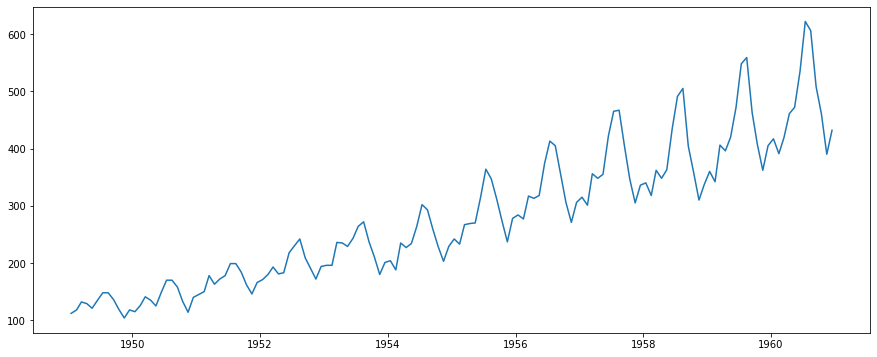

In [98]:
plt.plot(ts)

###  Observe seasonality and trend in the above graph

In [99]:
#transformation
ts_log = np.log(ts)

In [100]:
ts_log

Month
1949-01-15    4.718499
1949-02-15    4.770685
1949-03-15    4.882802
1949-04-15    4.859812
1949-05-15    4.795791
                ...   
1960-08-15    6.406880
1960-09-15    6.230481
1960-10-15    6.133398
1960-11-15    5.966147
1960-12-15    6.068426
Name: #Passengers, Length: 144, dtype: float64

In [101]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=40,center=False).mean() 
    rolstd = timeseries.rolling(window=40,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

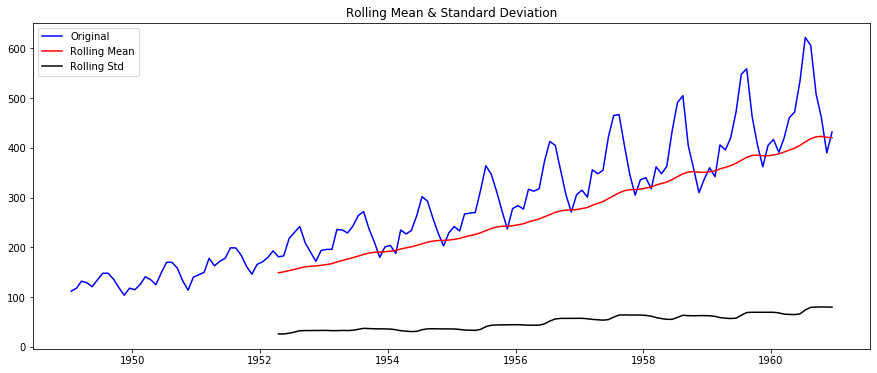

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [102]:
test_stationarity(data['#Passengers'])

###  The time series is not stationary 

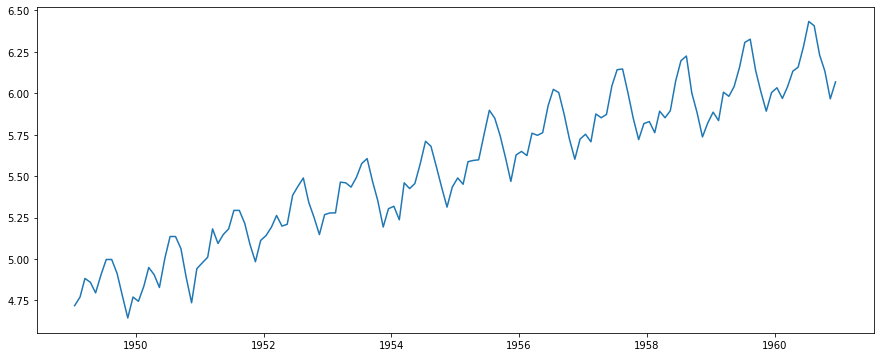

In [103]:
plt.plot(ts_log)

Month
1949-01-15    4.718499
1949-02-15    4.770685
1949-03-15    4.882802
1949-04-15    4.859812
1949-05-15    4.795791
                ...   
1960-08-15    6.406880
1960-09-15    6.230481
1960-10-15    6.133398
1960-11-15    5.966147
1960-12-15    6.068426
Name: #Passengers, Length: 144, dtype: float64

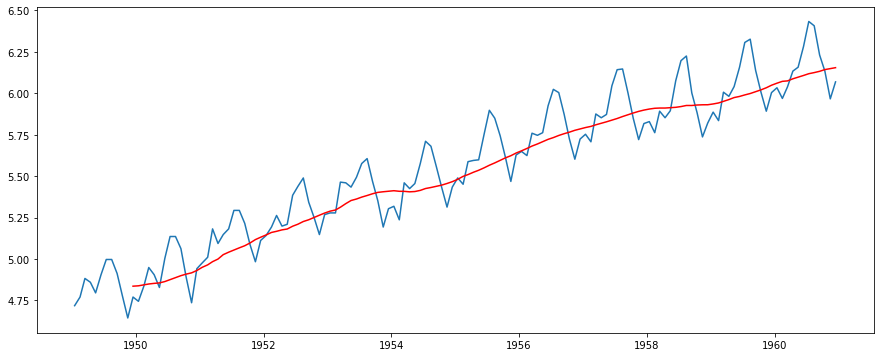

In [104]:
movingAverage = ts_log.rolling(window=12).mean()
movingSTD = ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAverage, color='red')
#plt.plot(movingSTD, color='green')
movingAverage
ts_log

In [105]:
# Get the difference between the moving average and the actual number of passengers
ts_log_mv_diff = ts_log - movingAverage
ts_log_mv_diff.head(12)
#Remove Nan Values
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
Name: #Passengers, dtype: float64

In [106]:
ts_log_mv_diff_shift = ts_log_mv_diff - ts_log_mv_diff.shift()

In [107]:
ts_log_mv_diff_shift.dropna(inplace=True)

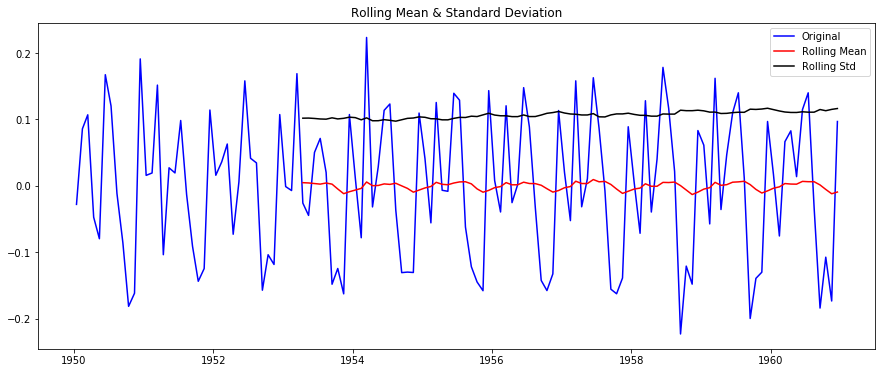

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [108]:
test_stationarity(ts_log_mv_diff_shift)

In [109]:
ts_log_mv_diff_shift

Month
1950-01-15   -0.027955
1950-02-15    0.085883
1950-03-15    0.106981
1950-04-15   -0.047274
1950-05-15   -0.079671
                ...   
1960-08-15   -0.032788
1960-09-15   -0.184128
1960-10-15   -0.107465
1960-11-15   -0.173460
1960-12-15    0.096901
Name: #Passengers, Length: 132, dtype: float64

In [110]:
acf(ts_log_mv_diff_shift, nlags = 10)

array([ 1.        ,  0.20522977, -0.11868154, -0.1444175 , -0.32075576,
       -0.08405742, -0.00507995, -0.11379782, -0.33529343, -0.10168094,
       -0.08997439])

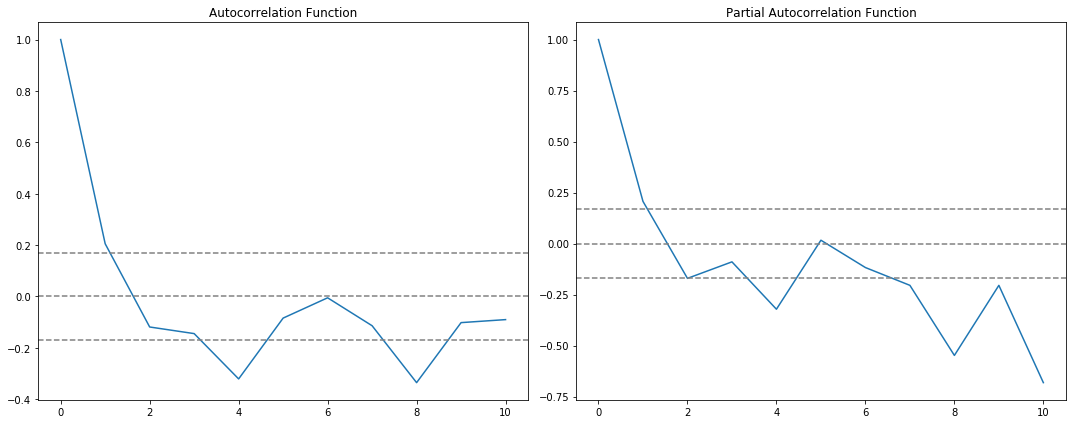

In [111]:
#ACF & PACF plots

lag_acf = acf(ts_log_mv_diff_shift, nlags = 10)
lag_pacf = pacf(ts_log_mv_diff_shift, nlags = 10)

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_mv_diff_shift)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_mv_diff_shift)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_mv_diff_shift)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_mv_diff_shift)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

Plotting AR model


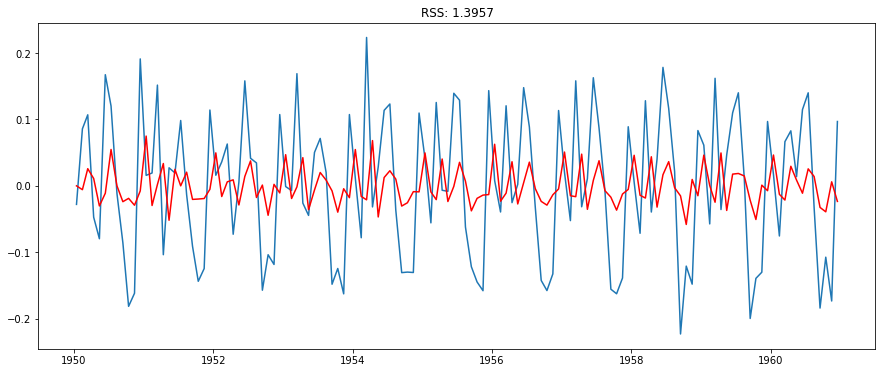

In [112]:
#AR Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(ts_log_mv_diff, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(ts_log_mv_diff_shift)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - ts_log_mv_diff_shift)**2))
print('Plotting AR model')

Plotting MA model


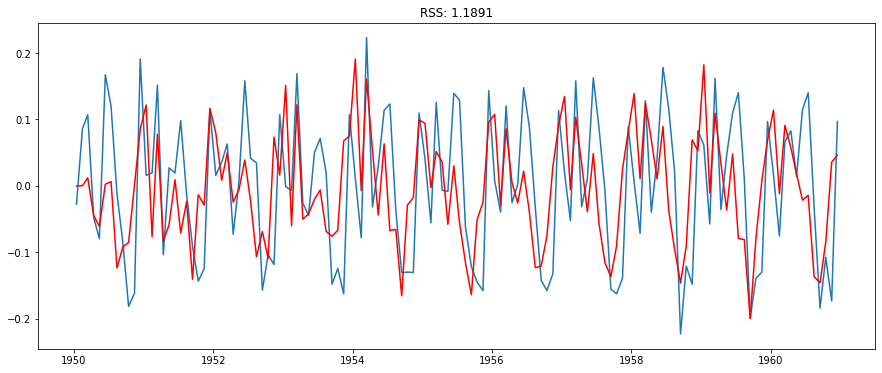

In [113]:
#MA Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(ts_log_mv_diff, order=(0,1,2))
results_AR = model.fit(disp=-1)
plt.plot(ts_log_mv_diff_shift)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - ts_log_mv_diff_shift)**2))
print('Plotting MA model')

Plotting ARIMA model


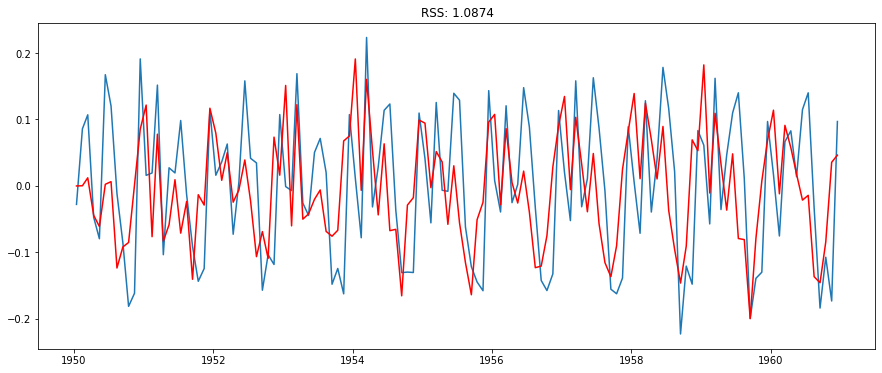

In [117]:
#ARIMA Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(ts_log_mv_diff, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_mv_diff_shift)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - ts_log_mv_diff_shift)**2))
print('Plotting ARIMA model')

In [118]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1950-01-15   -0.000163
1950-02-15   -0.001924
1950-03-15    0.017429
1950-04-15   -0.022264
1950-05-15   -0.043580
dtype: float64


In [119]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Month
1950-01-15   -0.000163
1950-02-15   -0.002087
1950-03-15    0.015342
1950-04-15   -0.006922
1950-05-15   -0.050501
                ...   
1960-08-15   -0.269374
1960-09-15   -0.363902
1960-10-15   -0.429656
1960-11-15   -0.407113
1960-12-15   -0.397486
Length: 132, dtype: float64


In [120]:
predictions_ARIMA_log = pd.Series(ts_log, index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-15    4.718499
1949-02-15    4.770685
1949-03-15    4.882802
1949-04-15    4.859812
1949-05-15    4.795791
dtype: float64

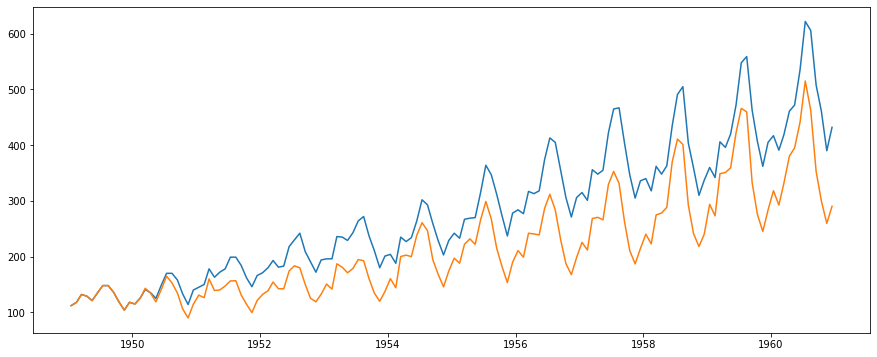

In [121]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)